In [1]:
import os.path as osp

import pandas as pd
import numpy as np
import torch
import clip
import seaborn as sns

from emotionpredictor.training import SLP
import emotionpredictor.evaluation as evaluation

%config InlineBackend.figure_format ='retina'

# Text input


## As predictor

In [2]:
artemis_preprossed_path = "../../code/artemis/artemis/data/artemis_preprocessed.csv"
clip_architecture = "RN50x16" 
emotion_models_path = f"../../neural_checkpoints/" 
emotion_model_path = osp.join(emotion_models_path, f"C-{clip_architecture}")

In [3]:
ARTEMIS_EMOTIONS = ['amusement',
 'awe',
 'contentment',
 'excitement',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'something else']

In [4]:
dataset = pd.read_csv(artemis_preprossed_path)
subset = dataset[dataset.split == "test"]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
clip_model, _ = clip.load(clip_architecture)
clip_model.eval();

In [7]:
model = SLP(input_size=768)
model.load_state_dict(torch.load(emotion_model_path))
model.eval().to(device)

SLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=9, bias=True)
  )
)

In [8]:
def get_text_encoding(texts, text_encoder):
    text = clip.tokenize(texts).to(device)
    with torch.no_grad():
        text_features = text_encoder(text)
    return text_features
    
with torch.no_grad():
    subset["emotion_pred"] = subset\
        .utterance_spelled\
        .map(lambda y : model(get_text_encoding(y, clip_model.encode_text)).argmax())
    subset.emotion_pred = subset.emotion_pred.map(lambda y : y.detach().cpu().numpy())
    (subset["emotion_label"] == subset["emotion_pred"]).sum()

/tmp/ipykernel_53770/297869818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["emotion_pred"] = subset\
/home/robin/miniconda/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
accuracy = ((subset["emotion_label"] == subset["emotion_pred"]).sum()/len(subset.index))*100
print(f"Overall accuracy : {accuracy:.2f}%")

Overall accuracy : 40.36%


<Figure size 432x288 with 0 Axes>

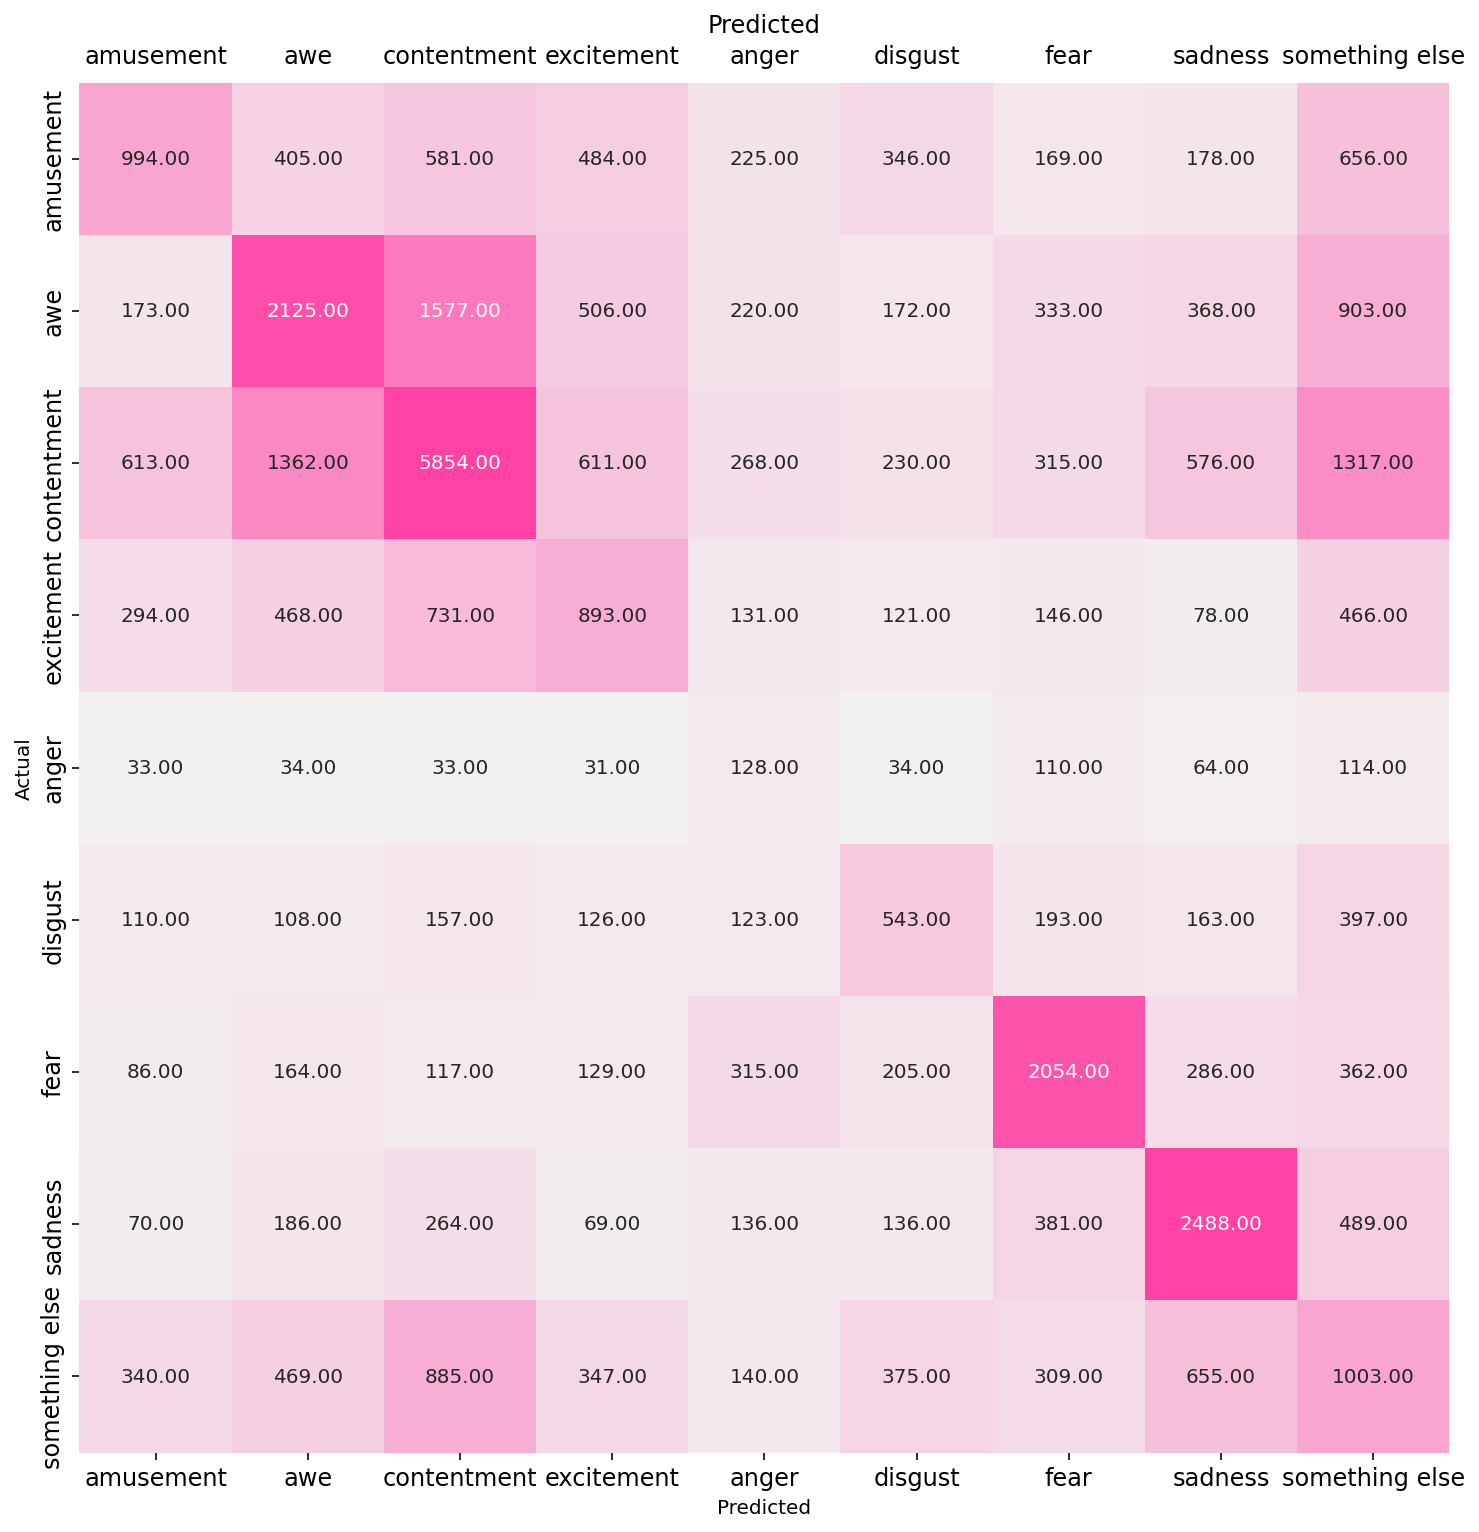

In [10]:
mat = evaluation.confusion_matrix(y_true=subset["emotion_label"], y_pred=subset["emotion_pred"])
evaluation.plot_confusion_matrix(pd.DataFrame(mat, columns=ARTEMIS_EMOTIONS, index=ARTEMIS_EMOTIONS))

## Text maximising emotions

In [11]:
sentences = dataset.utterance

In [12]:
dataset_eq = dataset.groupby("emotion").sample(100)
sentences = dataset_eq.utterance
sentences = sentences.map(clip.tokenize)
s = torch.cat(sentences.to_list())

In [29]:

with torch.no_grad():
    #for x in torch.utils.data.DataLoader(s, batch_size = 50):
    encoded = clip_model.encode_text(s.to(device))
    predicted = model(encoded).cpu()

In [35]:
max_sentences = []
for i, emotion in enumerate(ARTEMIS_EMOTIONS):
    v, indices = predicted.softmax(1)[:,i].topk(3)
    for i,indice in enumerate(indices) :
        max_sentences.append([emotion, round(v[i].data.tolist()*100),dataset_eq.emotion.iloc[indice.numpy()],dataset_eq.utterance.iloc[indice.numpy()]])
        a = dataset_eq[["emotion", "utterance"]].iloc[indices.numpy()]
        #print(round(v[i].data.tolist()*100))
        #print(f"{dataset_eq.emotion.iloc[indice.numpy()]},",dataset_eq.utterance.iloc[indice.numpy()])
sentences = pd.DataFrame(max_sentences, columns = ["Predicted", "Confidence", "Actual", "Description"]).set_index(["Predicted", "Description"])
sentences
#save_latek("../results/tables/softmax_sentences.tex", sentences.to_latex(multirow = True))

Confidence  \
Predicted      Description                                                      
amusement      The man seems gleeful as he poses for his portr...         100   
               The characters are somically shaped and it feel...         100   
               There is a sense of amusement in this image, it...          99   
awe            The scene is quite majestic in the way the god-...         100   
               The statues in the ruins seem realistic and gra...          99   
               The purple, like royalty.  The gold like mans p...          99   
contentment    really pleasing color palate, very tranquil scene.         100   
               Very serene pastoral setting that evokes a sens...         100   
               The bond shown between the baby and mother make...         100   
excitement     The bright colors bring a bold energy to the pa...          99   
               I feel almost dizzy looking at this painting an...          98   
               While chaotic, it is lively with people enjoyin...          98   
anger          The man looks angry; likes he's scolding someone.          100   
               The look on his face makes me think he is angry...         100   
               My feelings match the angry expression on this ...          99   
disgust        this piece of art makes me angry because it loo...         100   
               The first think I thought of when I saw this wa...         100   
               the items on the plate look like moldy fruit                99   
fear           The dark look of these trees make this area    ...         100   
               I would not want to be onboard a ship this late...         100   
               the dark colors, and violent seas look scary, a...         100   
sadness        The muted colours and the forlorn look on her f...         100   
               The lady looks so sad and lonely. I feel bad fo...         100   
               the young angel looks sad, and if he is crying             100   
something else While it's an image of a forest there's nothing...          97   
               looks like the outline of a long since abandone...          97   
               Looks like a long grueling journey in the desert            96   

                                                                           Actual  
Predicted      Description                                                         
amusement      The man seems gleeful as he poses for his portr...       amusement  
               The characters are somically shaped and it feel...       amusement  
               There is a sense of amusement in this image, it...       amusement  
awe            The scene is quite majestic in the way the god-...             awe  
               The statues in the ruins seem realistic and gra...             awe  
               The purple, like royalty.  The gold like mans p...             awe  
contentment    really pleasing color palate, very tranquil scene.     contentment  
               Very serene pastoral setting that evokes a sens...     contentment  
               The bond shown between the baby and mother make...             awe  
excitement     The bright colors bring a bold energy to the pa...      excitement  
               I feel almost dizzy looking at this painting an...           anger  
               While chaotic, it is lively with people enjoyin...     contentment  
anger          The man looks angry; likes he's scolding someone.            anger  
               The look on his face makes me think he is angry...           anger  
               My feelings match the angry expression on this ...           anger  
disgust        this piece of art makes me angry because it loo...           anger  
               The first think I thought of when I saw this wa...         disgust  
               the items on the plate look like moldy fruit               disgust  
fear           The dark look of these

In [34]:
preds_fm = predicted.softmax(1)
max_sentences = []
for i, emotion in enumerate(ARTEMIS_EMOTIONS):
    v, indices = predicted[:,i].topk(3)
    for indice in indices :
        max_sentences.append([emotion, round(preds_fm[indice, i].data.tolist()*100),
                              dataset_eq.emotion.iloc[indice.numpy()],
                              dataset_eq.utterance.iloc[indice.numpy()]])
        a = dataset_eq[["emotion", "utterance"]].iloc[indices.numpy()]

sentences = pd.DataFrame(max_sentences, columns = ["Predicted", "Confidence", "Actual", "Description"]).set_index(["Predicted", "Description"])
#save_latek("../results/tables/maxed_sentences.tex", sentences.to_latex(multirow = True))

Confidence  \
Predicted      Description                                                      
amusement      There are many interesting things going on in t...          97   
               This is a funny take on the royalty on playing ...          93   
               Not sure what is going on in this scene, but I ...          83   
awe            The purple, like royalty.  The gold like mans p...          99   
               The sheer span of the angels wings look majesti...          99   
               The statues in the ruins seem realistic and gra...          99   
contentment    The bond shown between the baby and mother make...         100   
               Very serene pastoral setting that evokes a sens...         100   
               The peaceful landscape with animals and people ...          99   
excitement     I feel almost dizzy looking at this painting an...          98   
               The bright colors bring a bold energy to the pa...          99   
               The race cars depicted in this picture are cool...          95   
anger          The subject of the painting is drawn in a state...          97   
               The overly dark and bold lines suggest an angry...          98   
               The intensity of her face, coupled with the sta...          71   
disgust        Human lips, a pig's snout, and a bloody knife a...          80   
               the items on the plate look like moldy fruit                99   
               The first think I thought of when I saw this wa...         100   
fear           The gloomy texture of the building and the dark...         100   
               I would not want to be onboard a ship this late...         100   
               The dark look of these trees make this area    ...         100   
sadness        The muted colours and the forlorn look on her f...         100   
               Dark and sad painting with lots of abstract lin...         100   
               This reminds of a woman in the early 1900’s loo...         100   
something else Woman seems comfortable strolling through the f...          89   
               The woman's dress is so wide that it is more th...          80   
               Farmers either working on a farm or walking thr...          28   

                                                                        Actual  
Predicted      Description                                                      
amusement      There are many interesting things going on in t...    amusement  
               This is a funny take on the royalty on playing ...    amusement  
               Not sure what is going on in this scene, but I ...   excitement  
awe            The purple, like royalty.  The gold like mans p...          awe  
               The sheer span of the angels wings look majesti...          awe  
               The statues in the ruins seem realistic and gra...          awe  
contentment    The bond shown between the baby and mother make...          awe  
               Very serene pastoral setting that evokes a sens...  contentment  
               The peaceful landscape with animals and people ...  contentment  
excitement     I feel almost dizzy looking at this painting an...        anger  
               The bright colors bring a bold energy to the pa...   excitement  
               The race cars depicted in this picture are cool...   excitement  
anger          The subject of the painting is drawn in a state...        anger  
               The overly dark and bold lines suggest an angry...        anger  
               The intensity of her face, coupled with the sta...        anger  
disgust        Human lips, a pig's snout, and a bloody knife a...        anger  
               the items on the plate look like moldy fruit            disgust  
               The first think I thought of when I saw this wa...      disgust  
fear           The gloomy texture of the building and the dark...         fear  
               I